In [3]:
import os, shutil, json, math, random, heapq, time
import numpy as np
import cv2
import csv
import statistics
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from pathlib import Path
from typing import List, Tuple, Dict
from torch.amp import autocast, GradScaler

In [4]:
root = "/content/data/Sample"
img_root = f"{root}/01.원천데이터"      # .jpg
lab_root = f"{root}/02.라벨링데이터"    # .json

dataset_root = "/content/dataset"
images_root = f"{dataset_root}/images"  # .jpg (전처리 후)
labels_root = f"{dataset_root}/labels"  # .txt

splits = ["train", "val", "test"]

### 데이터 준비

In [5]:
# 초기화 후 CP949로 해제
!rm -rf /content/data && mkdir -p /content/data
!unzip -qq -O CP949 "/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/생성형 AI/data/art.zip" -d /content/data

In [6]:
import glob
from pathlib import Path
random.seed(2025)

for split in splits:
    os.makedirs(f"{dataset_root}/images/{split}", exist_ok=True)
    os.makedirs(f"{dataset_root}/labels/{split}", exist_ok=True)

# 각 클래스 폴더 순회
classes = os.listdir(img_root)
for cls in classes:
    img_paths = sorted(glob.glob(f"{img_root}/{cls}/*.jpg"))
    lab_paths = sorted(glob.glob(f"{lab_root}/{cls}/*.json"))

    # 이름 기준 매칭
    pairs = [(i, l) for i, l in zip(img_paths, lab_paths) if Path(i).stem == Path(l).stem]
    random.shuffle(pairs)

    n = len(pairs)
    n_train = int(n*0.8)
    n_val   = int(n*0.1)
    n_test  = n - n_train - n_val

    split_data = {
        "train": pairs[:n_train],
        "val":   pairs[n_train:n_train+n_val],
        "test":  pairs[n_train+n_val:]
    }

    # 복사
    for split, items in split_data.items():
        for imgf, labf in items:
            shutil.copy(imgf, f"{dataset_root}/images/{split}/{Path(imgf).name}")
            shutil.copy(labf, f"{dataset_root}/labels/{split}/{Path(labf).name}")

print("데이터셋 분리 완료 ✅")

데이터셋 분리 완료 ✅


### 데이터 분석

1. 클래스/박스 분포와 사이즈 특성 파악
2. 큰 객체 면적 범위와 비율 파악
3. 앵커 후보 추출(K-means, IoU 거리) & 계층 군집 시각화
4. YOLOv3 3-head(Strides 8/16/32)에 맞춘 앵커 매핑 기준 정리

In [7]:
def convert_split_jsons(split: str, labels_root: str, class_to_id: dict):
    """
    split: "train" / "val" / "test"
    labels_root: dataset_root/labels
    class_to_id: {"cls_name": id}
    """
    split_dir = Path(labels_root) / split
    json_paths = sorted(glob.glob(str(split_dir / "*.json")))

    stats_rows = []
    for jp in json_paths:
        with open(jp, "r", encoding="utf-8") as f:
            J = json.load(f)

        # 해상도
        W,H = None,None
        if "meta" in J and "img_resolution" in J["meta"]:
            W,H = map(int, J["meta"]["img_resolution"].lower().split("x"))

        stem = Path(jp).stem
        yolo_txt = split_dir / f"{stem}.txt"
        lines = []

        for b in J.get("annotations", {}).get("bbox", []):
            lab = str(b.get("label", "")).strip()
            if lab not in class_to_id: continue
            cid = class_to_id[lab]
            x,y,w,h = [float(b[k]) for k in ("x","y","w","h")]
            cx = (x + w/2.0) / W
            cy = (y + h/2.0) / H
            nw, nh = w/W, h/H
            lines.append(f"{cid} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")

            stats_rows.append({
                "split": split,
                "cls_name": lab,
                "cls_id": cid,
                "area_norm": nw*nh,
                "aspect": (nw/nh) if nh>0 else np.nan
            })

        if lines:
            with open(yolo_txt, "w", encoding="utf-8") as f:
                f.write("\n".join(lines))

    return pd.DataFrame(stats_rows)

# 전체 클래스 사전 만들기 (train/val/test 합쳐서)
all_jsons = glob.glob(str(Path(labels_root)/"*/*.json"))
cls_set = set()
for jp in all_jsons:
    with open(jp,"r",encoding="utf-8") as f:
        J=json.load(f)
    for b in J.get("annotations",{}).get("bbox",[]):
        cls_set.add(str(b.get("label","")).strip())
class_to_id = {c:i for i,c in enumerate(sorted(cls_set))}

# classes.txt 저장
with open(Path(dataset_root)/"classes.txt","w",encoding="utf-8") as f:
    for c in sorted(cls_set):
        f.write(c+"\n")

# split별 변환
df_all = []
for split in ["train","val","test"]:
    df_all.append(convert_split_jsons(split, labels_root, class_to_id))

df = pd.concat(df_all, ignore_index=True)
print("[DONE] json→txt 변환 완료")
display(df.head())

[DONE] json→txt 변환 완료


,split,cls_name,cls_id,area_norm,aspect
0,train,나무전체,9,0.367526,0.468254
1,train,기둥,5,0.059001,0.295455
2,train,수관,29,0.081721,1.044693
3,train,가지,0,0.018633,1.472222
4,train,가지,0,0.007793,2.210526


In [8]:
# class_summary.csv : 클래스별 총 개수, 평균 면적비, 면적 분위수(p25/p50/p75/p90), 평균 종횡비
# class_counts_by_split.csv: train/val/test 분포 불균형 확인
# class_size_mix_percent.csv: Tiny/Small/Medium/Large/XLarge 비율
#               → 어느 stride(8/16/32)에 앵커를 더 배치해야 하는지 근거

# 분석 산출물 저장 폴더
ana_dir = Path(dataset_root) / "analysis"
ana_dir.mkdir(parents=True, exist_ok=True)

# 1) 원본 df 보강: w_norm, h_norm, size_bucket
#    (area_norm = w*h, aspect = w/h  →  w = sqrt(area*aspect), h = sqrt(area/aspect))
df = df.copy()
df["w_norm"] = np.sqrt(df["area_norm"] * df["aspect"].clip(lower=1e-9))
df["h_norm"] = np.sqrt(df["area_norm"] / df["aspect"].clip(lower=1e-9))

def size_bucket(a):
    if a < 0.01:  return "Tiny(<1%)"
    if a < 0.05:  return "Small(1–5%)"
    if a < 0.20:  return "Medium(5–20%)"
    if a < 0.50:  return "Large(20–50%)"
    return "XLarge(>50%)"

df["size_bucket"] = df["area_norm"].apply(size_bucket)

# 2) 클래스별 요약표 (전체)
quantiles = {
    "p25_area": ("area_norm", lambda s: s.quantile(0.25)),
    "p50_area": ("area_norm", "median"),
    "p75_area": ("area_norm", lambda s: s.quantile(0.75)),
    "p90_area": ("area_norm", lambda s: s.quantile(0.90)),
}
class_summary = (df.groupby(["cls_id","cls_name"])
    .agg(
        count=("cls_id","size"),
        mean_area=("area_norm","mean"),
        mean_aspect=("aspect","mean"),
        **quantiles
    )
    .sort_values("count", ascending=False)
)

# 3) split별 개수 피벗
by_split = (df.groupby(["cls_name","split"]).size()
              .unstack(fill_value=0)
              .sort_values(["train","val","test"], ascending=False))

# 4) 클래스별 크기 구간 분포(%) 피벗
size_mix = (df.groupby(["cls_name","size_bucket"]).size()
              .groupby(level=0).apply(lambda s: (s/s.sum()*100).round(2))
              .unstack(fill_value=0)
              .sort_index())

# 5) “큰 객체” 후보 자동 검출(라벨명 힌트 기반)
BIG_HINTS = ["전체","전신","집전체","나무전체","full","whole","entire","overall"]
big_classes = [c for c in sorted(df["cls_name"].unique())
               if any(h in c for h in BIG_HINTS)]

# 저장
class_summary.round(6).to_csv(ana_dir/"class_summary.csv", encoding="utf-8-sig")
by_split.to_csv(ana_dir/"class_counts_by_split.csv", encoding="utf-8-sig")
size_mix.to_csv(ana_dir/"class_size_mix_percent.csv", encoding="utf-8-sig")

print(f"[OK] 분석 DF 저장 위치: {ana_dir}")
print(f"[INFO] big-classes guess: {big_classes[:10]}")
display(class_summary.head(20))
display(by_split.head(20))
display(size_mix.loc[big_classes] if len(big_classes) else size_mix.head(10))

[OK] 분석 DF 저장 위치: /content/dataset/analysis
[INFO] big-classes guess: ['나무전체', '사람전체', '집전체']


,,count,mean_area,mean_aspect,p25_area,p50_area,p75_area,p90_area
cls_id,cls_name,,,,,,,
7,꽃,637,0.008543,0.687198,0.003674,0.005939,0.010078,0.017366
12,눈,560,0.001217,1.219722,0.000360,0.000754,0.001579,0.002815
21,발,560,0.003800,1.421534,0.001755,0.003100,0.004818,0.007196
35,운동화,560,0.006319,1.337327,0.003369,0.005331,0.007665,0.011490
46,팔,560,0.017804,0.756031,0.008417,0.015231,0.022525,0.034159
14,다리,559,0.018638,0.501078,0.007885,0.014163,0.026034,0.038687
3,귀,557,0.001631,0.744391,0.000685,0.001129,0.001945,0.003475
28,손,557,0.002915,1.054339,0.001401,0.002393,0.003599,0.005059
38,잔디,525,0.011719,1.804927,0.001038,0.001951,0.003909,0.010161


split,test,train,val
cls_name,,,
꽃,57,522,58
눈,56,448,56
발,56,448,56
운동화,56,448,56
팔,56,448,56
다리,56,448,55
귀,55,446,56
손,56,445,56
잔디,44,437,44


,size_bucket,Large(20–50%),Medium(5–20%),Small(1–5%),Tiny(<1%),XLarge(>50%)
cls_name,cls_name,,,,,
나무전체,나무전체,52.14,8.57,0.00,0.00,39.29
사람전체,사람전체,50.36,38.93,5.00,0.00,5.71
집전체,집전체,40.00,49.29,7.14,0.71,2.86


k=6: avgIoU=0.6253
k=7: avgIoU=0.6404
k=8: avgIoU=0.6565
k=9: avgIoU=0.6695
k=10: avgIoU=0.6831
k=11: avgIoU=0.6937
k=12: avgIoU=0.7029


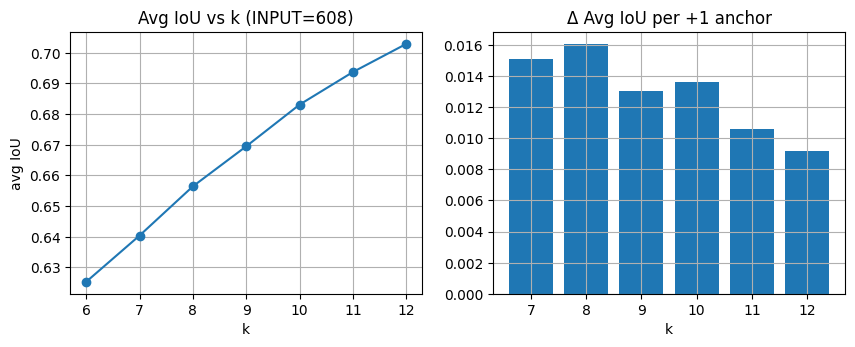

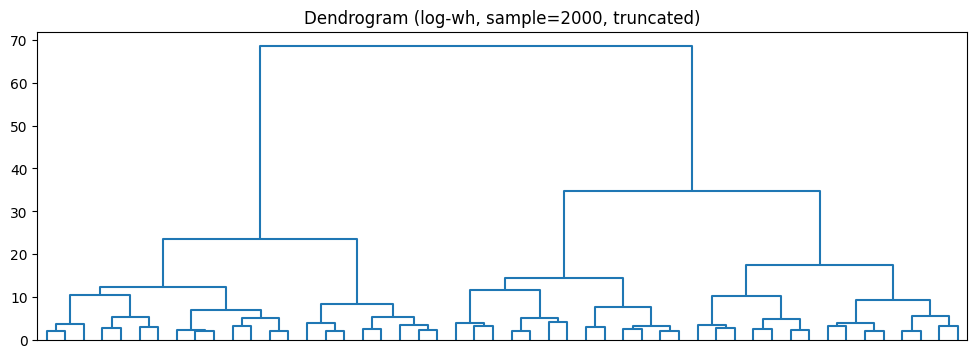

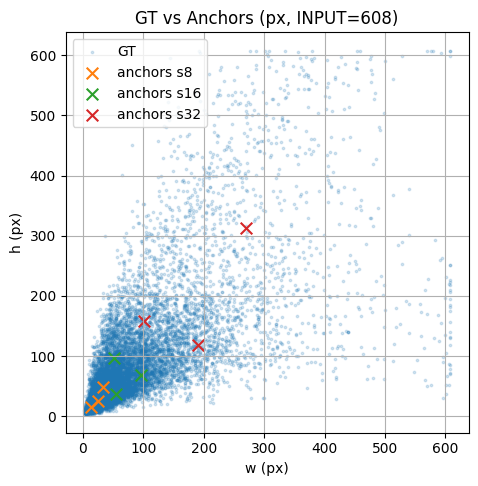


================ TEAM SUMMARY ================
Total boxes: 13822 | Classes: 47 | INPUT=608
Overall size mix (%): {'Tiny(<1%)': 60.25, 'Small(1–5%)': 24.43, 'Medium(5–20%)': 11.44, 'Large(20–50%)': 3.3, 'XLarge(>50%)': 0.58}
Big-class guess: ['나무전체', '사람전체', '집전체']
Big-class area stats (p50/p90/max): {"나무전체": {"count": 140, "p50": 0.4513, "p90": 0.7175, "max": 0.9984}, "사람전체": {"count": 280, "p50": 0.2108, "p90": 0.4196, "max": 0.7021}, "집전체": {"count": 140, "p50": 0.1869, "p90": 0.4264, "max": 0.7806}}
Anchors (px) -> stride8/16/32:
  s8 : [[14.199999809265137, 15.199999809265137], [25.600000381469727, 26.100000381469727], [33.20000076293945, 48.900001525878906]]
  s16: [[54.599998474121094, 37.5], [50.79999923706055, 96.9000015258789], [96.4000015258789, 67.9000015258789]]
  s32: [[101.19999694824219, 158.1999969482422], [190.0, 118.30000305175781], [270.79998779296875, 312.6000061035156]]
Anchors (grid units) saved -> /content/dataset/analysis/anchors_grid_608.json
CSV: /content/da

In [9]:
# ====== ALL-IN-ONE: 분석 + 앵커 + 엘보(Δ) + 개선 덴드로그램 + 산포 ======
import os, json, math, sys, subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scipy / sklearn 보장
try:
    from scipy.cluster.hierarchy import linkage, dendrogram
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy", "-q"])
    from scipy.cluster.hierarchy import linkage, dendrogram
try:
    from sklearn.preprocessing import StandardScaler
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn", "-q"])
    from sklearn.preprocessing import StandardScaler

# ====== 경로 ======
ana_dir = Path(dataset_root) / "analysis"
ana_dir.mkdir(parents=True, exist_ok=True)

# ====== 1) df 보강 ======
df = df.copy()
df["w_norm"] = np.sqrt(df["area_norm"] * df["aspect"].clip(lower=1e-9))
df["h_norm"] = np.sqrt(df["area_norm"] / df["aspect"].clip(lower=1e-9))

def size_bucket(a):
    if a < 0.01:  return "Tiny(<1%)"
    if a < 0.05:  return "Small(1–5%)"
    if a < 0.20:  return "Medium(5–20%)"
    if a < 0.50:  return "Large(20–50%)"
    return "XLarge(>50%)"

df["size_bucket"] = df["area_norm"].apply(size_bucket)

# ====== 2) 요약 DF 저장 ======
quantiles = {
    "p25_area": ("area_norm", lambda s: s.quantile(0.25)),
    "p50_area": ("area_norm", "median"),
    "p75_area": ("area_norm", lambda s: s.quantile(0.75)),
    "p90_area": ("area_norm", lambda s: s.quantile(0.90)),
}
class_summary = (df.groupby(["cls_id","cls_name"])
    .agg(count=("cls_id","size"),
         mean_area=("area_norm","mean"),
         mean_aspect=("aspect","mean"),
         **quantiles)
    .sort_values("count", ascending=False)
    .round(6))

by_split = (df.groupby(["cls_name","split"]).size()
              .unstack(fill_value=0)
              .sort_values(list(reversed(sorted(df["split"].unique()))), ascending=False))

size_mix = (df.groupby(["cls_name","size_bucket"]).size()
              .groupby(level=0).apply(lambda s: (s/s.sum()*100).round(2))
              .unstack(fill_value=0)
              .sort_index())

class_summary.to_csv(ana_dir/"class_summary.csv", encoding="utf-8-sig")
by_split.to_csv(ana_dir/"class_counts_by_split.csv", encoding="utf-8-sig")
size_mix.to_csv(ana_dir/"class_size_mix_percent.csv", encoding="utf-8-sig")

# ====== 3) 큰 객체 후보 ======
BIG_HINTS = ["전체","전신","집전체","나무전체","full","whole","entire","overall"]
big_classes = [c for c in sorted(df["cls_name"].unique()) if any(h in c for h in BIG_HINTS)]

# ====== 4) 앵커(KMeans IoU) ======
def _wh_iou(a, b):
    a = a[:, None, :]
    b = b[None, :, :]
    inter = np.minimum(a, b).prod(axis=2)
    area_a = a[...,0]*a[...,1]
    area_b = b[...,0]*b[...,1]
    union = area_a + area_b - inter + 1e-9
    return inter / union

def kmeans_iou_wh(wh, k=9, iters=80, seed=123):
    np.random.seed(seed)
    centers = [wh[np.random.randint(len(wh))]]
    for _ in range(1, k):
        dist = 1 - _wh_iou(wh, np.array(centers)).max(axis=1)
        probs = dist / (dist.sum()+1e-9)
        centers.append(wh[np.random.choice(len(wh), p=probs)])
    centers = np.array(centers)
    for _ in range(iters):
        iou = _wh_iou(wh, centers)
        assign = iou.argmax(axis=1)
        new_centers = []
        for j in range(k):
            pts = wh[assign==j]
            new_centers.append(np.median(pts, axis=0) if len(pts) else centers[j])
        new_centers = np.array(new_centers)
        if np.allclose(new_centers, centers): break
        centers = new_centers
    avg_iou = _wh_iou(wh, centers).max(axis=1).mean()
    return centers, avg_iou

# 입력 해상도 자동 결정(소객체 40% 이상이면 608)
small_ratio = (df["area_norm"] < 0.05).mean()
INPUT_SIZE = 608 if small_ratio >= 0.40 else 416

wh_px = (df[["w_norm","h_norm"]].values * INPUT_SIZE).astype(np.float32)

K_RANGE = range(6, 13)
avg_iou_list = []
for k in K_RANGE:
    C, ai = kmeans_iou_wh(wh_px, k=k, iters=120, seed=7)
    avg_iou_list.append(ai)
    print(f"k={k}: avgIoU={ai:.4f}")

# 엘보 + Δ 그래프
dAIoU = np.diff(avg_iou_list)
fig, ax = plt.subplots(1,2, figsize=(10,3.4))
ax[0].plot(list(K_RANGE), avg_iou_list, marker='o')
ax[0].set_title(f"Avg IoU vs k (INPUT={INPUT_SIZE})"); ax[0].set_xlabel("k"); ax[0].set_ylabel("avg IoU"); ax[0].grid(True)
ax[1].bar(list(K_RANGE)[1:], dAIoU)
ax[1].set_title("Δ Avg IoU per +1 anchor"); ax[1].set_xlabel("k"); ax[1].grid(True)
plt.show()

# 최종 9개(표준) 정렬 및 3스케일 배정
anchors_px, final_avg_iou = kmeans_iou_wh(wh_px, k=9, iters=200, seed=11)
anchors_px = anchors_px[np.argsort(anchors_px.prod(axis=1))]
a_s, a_m, a_l = anchors_px[:3], anchors_px[3:6], anchors_px[6:9]

anchors_out = {
    "input_size": INPUT_SIZE,
    "avg_iou": float(final_avg_iou),
    "anchors_px_sorted_area": anchors_px.round(1).tolist(),
    "stride8":  a_s.round(1).tolist(),
    "stride16": a_m.round(1).tolist(),
    "stride32": a_l.round(1).tolist(),
}
with open(ana_dir / f"anchors_{INPUT_SIZE}.json", "w", encoding="utf-8") as f:
    json.dump(anchors_out, f, ensure_ascii=False, indent=2)

# 그리드 단위(모델 주입용)
anchors_grid = {
    8:  (a_s/8.).round(3).tolist(),
    16: (a_m/16.).round(3).tolist(),
    32: (a_l/32.).round(3).tolist(),
}
with open(ana_dir / f"anchors_grid_{INPUT_SIZE}.json", "w", encoding="utf-8") as f:
    json.dump(anchors_grid, f, ensure_ascii=False, indent=2)

# ====== 5) 덴드로그램(개선: 표본추출+트렁케이션) ======
X = np.log(np.clip(wh_px, 1, None))
X = StandardScaler().fit_transform(X)
N = len(X)
sample_n = min(2000, N)
idx = np.random.default_rng(0).choice(N, size=sample_n, replace=False)
Z = linkage(X[idx], method="ward")

plt.figure(figsize=(12,4))
# 마지막 50개 클러스터만 보여주기 (가독성)
dendrogram(Z, no_labels=True, count_sort=True, distance_sort=True,
           truncate_mode="lastp", p=50, color_threshold=Z[-50,2]*0.7)
plt.title(f"Dendrogram (log-wh, sample={sample_n}, truncated)")
plt.show()

# ====== 6) 산포: GT vs Anchors ======
plt.figure(figsize=(5.2,5.2))
plt.scatter(wh_px[:,0], wh_px[:,1], s=3, alpha=0.18, label="GT")
plt.scatter(a_s[:,0], a_s[:,1], s=70, marker="x", label="anchors s8")
plt.scatter(a_m[:,0], a_m[:,1], s=70, marker="x", label="anchors s16")
plt.scatter(a_l[:,0], a_l[:,1], s=70, marker="x", label="anchors s32")
plt.xlabel("w (px)"); plt.ylabel("h (px)"); plt.title(f"GT vs Anchors (px, INPUT={INPUT_SIZE})")
plt.legend(); plt.grid(True); plt.show()

# ====== 7) TEAM SUMMARY ======
overall_size_mix = (df["size_bucket"].value_counts(normalize=True)*100).round(2).to_dict()
big_stats = {}
for cname in big_classes[:8]:
    s = df[df["cls_name"]==cname]["area_norm"]
    if len(s):
        big_stats[cname] = {
            "count": int(len(s)),
            "p50": round(float(s.median()),4),
            "p90": round(float(s.quantile(0.9)),4),
            "max": round(float(s.max()),4),
        }

print("\n================ TEAM SUMMARY ================")
print(f"Total boxes: {len(df)} | Classes: {df['cls_name'].nunique()} | INPUT={INPUT_SIZE}")
print("Overall size mix (%):", overall_size_mix)
print("Big-class guess:", big_classes[:8])
print("Big-class area stats (p50/p90/max):", json.dumps(big_stats, ensure_ascii=False))
print("Anchors (px) -> stride8/16/32:")
print("  s8 :", np.round(a_s,1).tolist())
print("  s16:", np.round(a_m,1).tolist())
print("  s32:", np.round(a_l,1).tolist())
print("Anchors (grid units) saved ->", ana_dir / f"anchors_grid_{INPUT_SIZE}.json")
print("CSV:", str(ana_dir/"class_summary.csv"),
      "|", str(ana_dir/"class_counts_by_split.csv"),
      "|", str(ana_dir/"class_size_mix_percent.csv"))
print("ANCHORS JSON:", str(ana_dir / f"anchors_{INPUT_SIZE}.json"))
print("==============================================")

In [10]:
# 앵커 주입 (INPUT=608, stride=8/16/32)
INPUT_SIZE = 608  # 소객체 비율이 높아 608 채택

# 픽셀 단위 앵커 (면적 오름차순 정렬, 3x3로 배정)
anchors_px = {
    8:  np.array([[14.2,15.2],[25.6,26.1],[33.2,48.9]], dtype=np.float32),
    16: np.array([[54.6,37.5],[50.8,96.9],[96.4,67.9]], dtype=np.float32),
    32: np.array([[101.2,158.2],[190.0,118.3],[270.8,312.6]], dtype=np.float32),
}

# 모델 주입용(그리드 단위 = anchor / stride)
anchors_grid = {s:(anchors_px[s]/s).astype(np.float32) for s in (8,16,32)}
strides = [8,16,32]
num_classes = 47  # TEAM SUMMARY 기준

print("anchors_grid:", {k: np.round(v,3).tolist() for k,v in anchors_grid.items()})

anchors_grid: {8: [[1.774999976158142, 1.899999976158142], [3.200000047683716, 3.26200008392334], [4.150000095367432, 6.111999988555908]], 16: [[3.4119999408721924, 2.3440001010894775], [3.174999952316284, 6.056000232696533], [6.025000095367432, 4.24399995803833]], 32: [[3.1619999408721924, 4.943999767303467], [5.938000202178955, 3.697000026702881], [8.461999893188477, 9.769000053405762]]}


### 데이터 전처리/증강 (mosaic + HSV + flip + resize 608)

In [11]:
# Config (based on anchors_grid)
INPUT_SIZE = 608
anchors_grid = {
    8:  np.array([[1.775, 1.900],[3.200, 3.262],[4.150, 6.112]], dtype=np.float32),
    16: np.array([[3.412, 2.344],[3.175, 6.056],[6.025, 4.244]], dtype=np.float32),
    32: np.array([[3.162, 4.944],[5.938, 3.697],[8.462, 9.769]], dtype=np.float32),
}
# (참고) 픽셀 단위 앵커
anchors_px = {s: anchors_grid[s]*s for s in anchors_grid}

# 증강 강도(소객체 ↑ → mosaic/multiscale 강화)
MOSAIC_PROB = 0.6
MIXUP_PROB  = 0.2        # 필요 없으면 0.0
HFLIP_PROB  = 0.5
HSV_GAIN    = (0.015, 0.7, 0.4)  # (h, s, v)
AFFINE_DEG  = 0.0        # 회전은 보수적으로 (필요시 5~10도)
AFFINE_SCL  = (0.5, 1.5) # scale jitter
AFFINE_TR   = 0.10       # translate 비율(±10%)
MULTISCALE  = (352, 640) # [min, max], step 32

In [12]:
# IO helpers
def load_img(path):
    # 한글경로 호환
    img = cv2.imdecode(np.fromfile(str(path), dtype=np.uint8), cv2.IMREAD_COLOR)
    if img is None: img = cv2.imread(str(path))
    return img

def read_yolo_txt(txt_path):
    labels=[]
    p = Path(txt_path)
    if p.exists():
        with open(p, "r", encoding="utf-8") as f:
            for ln in f:
                if not ln.strip(): continue
                c,x,y,w,h = map(float, ln.strip().split())
                labels.append([int(c), x, y, w, h])
    return np.array(labels, dtype=np.float32) if labels else np.zeros((0,5), np.float32)

def clip_labels_xywh(labels):
    if labels.size==0: return labels
    labels[:,1:] = np.clip(labels[:,1:], 0.0, 1.0)
    return labels

def otsu_binarize_bgr(img):
    # img: BGR uint8
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)  # 선택
    # 배경=검정, 선=흰색을 원하므로 INV 사용
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return cv2.cvtColor(th, cv2.COLOR_GRAY2BGR)

In [13]:
# Geometric utils

def letterbox(img, labels, target=INPUT_SIZE, border=114):
    h, w = img.shape[:2]
    scale = target / max(h,w)
    nh, nw = int(round(h*scale)), int(round(w*scale))
    img2 = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    canvas = np.full((target, target, 3), border, dtype=np.uint8)
    pad_y = (target - nh)//2
    pad_x = (target - nw)//2
    canvas[pad_y:pad_y+nh, pad_x:pad_x+nw] = img2

    if labels.size:
        cx = labels[:,1]*w*scale + pad_x
        cy = labels[:,2]*h*scale + pad_y
        bw = labels[:,3]*w*scale
        bh = labels[:,4]*h*scale
        labels[:,1] = cx/target; labels[:,2] = cy/target
        labels[:,3] = bw/target; labels[:,4] = bh/target
        labels = clip_labels_xywh(labels)
    return canvas, labels

def random_hflip(img, labels, p=HFLIP_PROB):
    if random.random() < p:
        img = img[:, ::-1, :]
        if labels.size:
            labels[:,1] = 1.0 - labels[:,1]
    return img, labels

def random_hsv(img):
    r = (np.random.uniform(-1,1,3) * np.array(HSV_GAIN)).astype(np.float32)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    h,s,v = cv2.split(hsv)
    h = (h + r[0]*180) % 180
    s = np.clip(s*(1+r[1]), 0, 255)
    v = np.clip(v*(1+r[2]), 0, 255)
    hsv = cv2.merge([h,s,v]).astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def random_affine(img, labels, degrees=AFFINE_DEG, scale=AFFINE_SCL, translate=AFFINE_TR):
    h, w = img.shape[:2]
    # params
    ang = random.uniform(-degrees, degrees)
    sc  = random.uniform(scale[0], scale[1])
    tx  = random.uniform(-translate, translate) * w
    ty  = random.uniform(-translate, translate) * h
    # matrix
    M  = cv2.getRotationMatrix2D((w/2, h/2), ang, sc)
    M[:,2] += (tx, ty)
    img2 = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=(114,114,114))
    if labels.size:
        # xywh(norm) -> corners(px) -> affine -> back to xywh(norm)
        cx = labels[:,1]*w; cy = labels[:,2]*h
        bw = labels[:,3]*w; bh = labels[:,4]*h
        x1 = cx - bw/2; y1 = cy - bh/2
        x2 = cx + bw/2; y2 = cy + bh/2
        corners = np.stack([x1,y1,x2,y2], 1)
        # 4 corners
        pts = np.stack([
            np.stack([x1,y1],1),
            np.stack([x2,y1],1),
            np.stack([x2,y2],1),
            np.stack([x1,y2],1)
        ],1)  # [N,4,2]
        ones = np.ones((pts.shape[0], pts.shape[1], 1))
        pts1 = np.concatenate([pts, ones], axis=2)  # [N,4,3]
        pts2 = np.einsum('ij,nkj->nki', np.vstack([M, [0,0,1]]), pts1)  # [N,4,3] -> [N,4,3]
        pts2 = pts2[...,:2]
        x1y1 = pts2.min(1); x2y2 = pts2.max(1)
        # back to xywh norm
        cx = (x1y1[:,0]+x2y2[:,0])/2; cy = (x1y1[:,1]+x2y2[:,1])/2
        bw = (x2y2[:,0]-x1y1[:,0]);   bh = (x2y2[:,1]-x1y1[:,1])
        labels[:,1] = cx/w; labels[:,2] = cy/h
        labels[:,3] = bw/w; labels[:,4] = bh/h
        # clip & remove invalid
        labels = clip_labels_xywh(labels)
        keep = (labels[:,3]>1e-4) & (labels[:,4]>1e-4)
        labels = labels[keep]
    return img2, labels

In [14]:
# Mosaic / MixUp
# --------------------
def _load_pair(img_path, lbl_path):
    img = load_img(img_path)
    h,w = img.shape[:2]
    labels = read_yolo_txt(lbl_path)
    return img, labels, (h,w)

def mosaic4(img_paths, lbl_paths, idxs):
    s = INPUT_SIZE
    yc, xc = [int(random.uniform(s*0.3, s*0.7)) for _ in range(2)]
    out = np.full((s, s, 3), 114, dtype=np.uint8)
    boxes = []

    for i, idx in enumerate(idxs):
        img, lab, (h,w) = _load_pair(img_paths[idx], lbl_paths[idx])
        # scale to random (소객체 유지하려고 너무 큰 축소 금지)
        scale = random.uniform(0.5, 0.9) * s / max(h, w)
        nh, nw = int(h*scale), int(w*scale)
        img = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)

        if i == 0:   # top-left
            x1a,y1a,x2a,y2a = max(xc-nw,0), max(yc-nh,0), xc, yc
            x1b,y1b,x2b,y2b = nw-(x2a-x1a), nh-(y2a-y1a), nw, nh
        elif i == 1: # top-right
            x1a,y1a,x2a,y2a = xc, max(yc-nh,0), min(xc+nw, s), yc
            x1b,y1b,x2b,y2b = 0, nh-(y2a-y1a), x2a-x1a, nh
        elif i == 2: # bottom-left
            x1a,y1a,x2a,y2a = max(xc-nw,0), yc, xc, min(yc+nh, s)
            x1b,y1b,x2b,y2b = nw-(x2a-x1a), 0, nw, y2a-y1a
        else:        # bottom-right
            x1a,y1a,x2a,y2a = xc, yc, min(xc+nw, s), min(yc+nh, s)
            x1b,y1b,x2b,y2b = 0, 0, x2a-x1a, y2a-y1a

        out[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]

        if lab.size:
            cx = lab[:,1]*w*scale + (x1a - x1b)
            cy = lab[:,2]*h*scale + (y1a - y1b)
            bw = lab[:,3]*w*scale
            bh = lab[:,4]*h*scale
            lab[:,1] = np.clip(cx/s, 0, 1)
            lab[:,2] = np.clip(cy/s, 0, 1)
            lab[:,3] = np.clip(bw/s, 0, 1)
            lab[:,4] = np.clip(bh/s, 0, 1)
            boxes.append(lab)

    boxes = np.concatenate(boxes, 0) if boxes else np.zeros((0,5), np.float32)
    out = random_hsv(out)
    out, boxes = random_hflip(out, boxes)
    return out, boxes

def mixup(img1, lab1, img2, lab2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    img = (img1.astype(np.float32)*lam + img2.astype(np.float32)*(1-lam)).astype(np.uint8)
    if lab1.size and lab2.size:
        labels = np.concatenate([lab1, lab2], 0)
    else:
        labels = lab1 if lab1.size else lab2
    return img, labels

In [15]:
#  소객체 부스팅: 매우 작은 박스를 랜덤 복제-붙여넣기

def boost_small_objects(img, labels, area_thr=0.01, max_copies=3):
    if labels.size==0: return img, labels
    H, W = img.shape[:2]
    small = labels[(labels[:,3]*labels[:,4]) < area_thr]
    if small.size==0: return img, labels
    new_boxes=[]
    for b in small:
        for _ in range(random.randint(0, max_copies)):
            # 약간의 이동
            dx = random.uniform(-0.05, 0.05)
            dy = random.uniform(-0.05, 0.05)
            nb = b.copy()
            nb[1] = np.clip(nb[1]+dx, 0, 1)
            nb[2] = np.clip(nb[2]+dy, 0, 1)
            new_boxes.append(nb)
    if new_boxes:
        labels = np.concatenate([labels, np.stack(new_boxes)], 0)
    return img, labels

In [16]:
# Dataset (전처리/증강만)
class YoloDataset(Dataset):
    def __init__(self, images_dir, labels_dir, split="train",
                 mosaic_prob=MOSAIC_PROB, mixup_prob=MIXUP_PROB,
                 enable_small_boost=True, base_size=608):
        self.split = split
        self.imgs = sorted(glob.glob(str(Path(images_dir)/split/"*.*")))
        ok = {".jpg",".jpeg",".png",".bmp",".webp"}
        self.imgs = [p for p in self.imgs if Path(p).suffix.lower() in ok]
        self.lbls = [str(Path(labels_dir)/split/(Path(p).stem + ".txt")) for p in self.imgs]
        self.mosaic_prob = mosaic_prob if split=="train" else 0.0
        self.mixup_prob  = mixup_prob  if split=="train" else 0.0
        self.enable_small_boost = enable_small_boost and split=="train"

        # 멀티스케일은 collate에서 배치 단위로 적용 → 여기서는 고정 base_size만 사용
        self.base_size = base_size

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, i):
        # 이 샘플에서 사용할 고정 입력 크기
        # (mosaic4/letterbox가 INPUT_SIZE 전역을 참조하므로 안전하게 동기화)
        global INPUT_SIZE
        INPUT_SIZE = self.base_size

        if self.mosaic_prob>0 and random.random()<self.mosaic_prob and len(self.imgs)>=4:
            # mosaic 4장 (첫 장 고정 + 추가 3장 랜덤)
            n = len(self.imgs)
            idxs = [i] + random.sample(range(n), 3)
            img, labels = mosaic4(self.imgs, self.lbls, idxs)
            # 약한 affine으로 경계 부드럽게
            img, labels = random_affine(img, labels, degrees=AFFINE_DEG)
            # mixup (확률)
            if self.mixup_prob>0 and random.random()<self.mixup_prob:
                j = random.randrange(n)
                img2 = load_img(self.imgs[j])
                lab2 = read_yolo_txt(self.lbls[j])
                img2, lab2 = letterbox(img2, lab2, target=INPUT_SIZE)
                img, labels = mixup(img, labels, img2, lab2, alpha=0.2)
        else:
            # 단일 이미지 경로
            img = load_img(self.imgs[i]); labels = read_yolo_txt(self.lbls[i])
            img, labels = letterbox(img, labels, target=INPUT_SIZE)
            img, labels = random_affine(img, labels, degrees=AFFINE_DEG)
            img = otsu_binarize_bgr(img)
            img = random_hsv(img)
            img, labels = random_hflip(img, labels)

        # (옵션) 소객체 부스팅
        if self.enable_small_boost:
            img, labels = boost_small_objects(img, labels, area_thr=0.01, max_copies=2)

        # 안전 클리핑 & 노멀라이즈 보장
        labels = clip_labels_xywh(labels)

        # to tensor
        img = img[:, :, ::-1]  # BGR->RGB
        img = img.astype(np.float32)/255.0
        img = np.transpose(img, (2,0,1))
        return torch.from_numpy(img), torch.from_numpy(labels)

In [39]:
MS_SIZES = list(range(352, 640+1, 32))  # 멀티스케일 후보(32 step)

def collate_fn_train(batch):
    imgs, labels = list(zip(*batch))
    # 배치 공통 크기 하나를 선택해서 모두 통일
    target_size = random.choice(MS_SIZES)
    imgs = [F.interpolate(img.unsqueeze(0), size=(target_size, target_size),
                          mode='bilinear', align_corners=False).squeeze(0)
            for img in imgs]
    imgs = torch.stack(imgs, 0)
    return imgs, list(labels)

def collate_fn_val(batch):
    imgs, labels = list(zip(*batch))
    target_size = 608  # 검증은 고정
    imgs = [F.interpolate(img.unsqueeze(0), size=(target_size, target_size),
                          mode='bilinear', align_corners=False).squeeze(0)
            for img in imgs]
    imgs = torch.stack(imgs, 0)
    return imgs, list(labels)

# Dataloaders (전처리/증강 확인용)
train_set = YoloDataset(images_root, labels_root, split="train",
                           mosaic_prob=MOSAIC_PROB, mixup_prob=MIXUP_PROB,
                           enable_small_boost=True, base_size=608)
val_set   = YoloDataset(images_root, labels_root, split="val",
                           mosaic_prob=0.0, mixup_prob=0.0, enable_small_boost=False, base_size=608)

train_loader = DataLoader(
    train_set, batch_size=4, shuffle=True,
    num_workers=2,  # 시스템 권장치에 맞춤
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate_fn_train
)

val_loader = DataLoader(
    val_set, batch_size=4, shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate_fn_val
)

len(train_set), len(val_set)

(448, 56)

In [44]:
# ==== Inspect a single sample's targets structure ====
import torch, numpy as np
from pprint import pprint

def _shape_of(x):
    if isinstance(x, torch.Tensor):
        return tuple(x.shape), str(x.dtype), "torch"
    if isinstance(x, np.ndarray):
        return tuple(x.shape), str(x.dtype), "numpy"
    if isinstance(x, (list, tuple)):
        return f"len={len(x)}", type(x).__name__, "seq"
    if isinstance(x, dict):
        return f"keys={list(x.keys())}", "dict", "dict"
    return "-", type(x).__name__, "other"

def _print_tree(x, prefix="targets"):
    if isinstance(x, torch.Tensor):
        print(f"{prefix}: Tensor shape={tuple(x.shape)} dtype={x.dtype} device={x.device}")
    elif isinstance(x, np.ndarray):
        print(f"{prefix}: ndarray shape={x.shape} dtype={x.dtype}")
    elif isinstance(x, dict):
        print(f"{prefix}: dict keys={list(x.keys())}")
        for k, v in x.items():
            _print_tree(v, prefix=f"{prefix}['{k}']")
    elif isinstance(x, (list, tuple)):
        print(f"{prefix}: {type(x).__name__} len={len(x)}")
        for i, v in enumerate(x):
            _print_tree(v, prefix=f"{prefix}[{i}]")
    else:
        print(f"{prefix}: {type(x).__name__} value={x}")

def inspect_sample(ds, idx=0):
    sample = ds[idx]
    if isinstance(sample, (list, tuple)) and len(sample) >= 2:
        img, targets = sample[0], sample[1]
    else:
        raise RuntimeError("dataset.__getitem__ must return (image, targets). 다른 형식이면 알려주세요.")
    print("=== IMAGE ===")
    s, t, src = _shape_of(img)
    if src == "torch":
        print(f"image: Tensor shape={s} dtype={t}")
    elif src == "numpy":
        print(f"image: ndarray shape={s} dtype={t}")
    else:
        print(f"image: type={t}, meta={s}")

    print("\n=== TARGETS (full tree) ===")
    _print_tree(targets)

    print("\n=== TARGETS (summary per leaf) ===")
    def _collect(x, key="targets"):
        leaves = []
        if isinstance(x, dict):
            for k, v in x.items():
                leaves += _collect(v, f"{key}['{k}']")
        elif isinstance(x, (list, tuple)):
            for i, v in enumerate(x):
                leaves += _collect(v, f"{key}[{i}]")
        else:
            leaves.append((key, _shape_of(x)))
        return leaves
    for path, info in _collect(targets):
        print(f"{path}: {info}")

# 사용 예시:
# dataset 변수명에 맞춰서 호출
inspect_sample(val_set, idx=0)   # 0번째 샘플
# inspect_sample(dataset, idx=5) # 다른 인덱스도 보고 싶으면

=== IMAGE ===
image: Tensor shape=(3, 608, 608) dtype=torch.float32

=== TARGETS (full tree) ===
targets: Tensor shape=(28, 5) dtype=torch.float32 device=cpu

=== TARGETS (summary per leaf) ===
targets: ((28, 5), 'torch.float32', 'torch')


### YOLOv3 모델 구현

In [18]:
# =====================================================================
# YOLOv3 (Darknet-53 backbone + 3-scale heads) with decode()
# =====================================================================

# -------------------------
# Building blocks
# -------------------------
class ConvBNAct(nn.Module):
    def __init__(self, in_ch, out_ch, k=1, s=1, p=None):
        super().__init__()
        if p is None:
            p = (k - 1) // 2
        self.conv = nn.Conv2d(in_ch, out_ch, k, s, p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.LeakyReLU(0.1, inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.cv1 = ConvBNAct(ch, ch//2, k=1, s=1)
        self.cv2 = ConvBNAct(ch//2, ch, k=3, s=1)
    def forward(self, x):
        return x + self.cv2(self.cv1(x))

# -------------------------
# Darknet-53 backbone
# -------------------------
class Darknet53(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem  = ConvBNAct(3, 32, 3, 1)
        self.down1 = nn.Sequential(ConvBNAct(32, 64, 3, 2), ResidualBlock(64))
        self.down2 = nn.Sequential(ConvBNAct(64, 128, 3, 2), *[ResidualBlock(128) for _ in range(2)])
        self.down3 = nn.Sequential(ConvBNAct(128, 256, 3, 2), *[ResidualBlock(256) for _ in range(8)])  # C3
        self.down4 = nn.Sequential(ConvBNAct(256, 512, 3, 2), *[ResidualBlock(512) for _ in range(8)])  # C4
        self.down5 = nn.Sequential(ConvBNAct(512, 1024, 3, 2), *[ResidualBlock(1024) for _ in range(4)]) # C5
    def forward(self, x):
        x = self.stem(x)
        x = self.down1(x)
        x = self.down2(x)
        c3 = self.down3(x)
        c4 = self.down4(c3)
        c5 = self.down5(c4)
        return c3, c4, c5

# -------------------------
# Detection head
# -------------------------
class DetectHead(nn.Module):
    def __init__(self, num_classes, anchors_13, anchors_26, anchors_52):
        super().__init__()
        self.nc = num_classes
        self.na = 3
        self.register_buffer("anchors_13", torch.tensor(anchors_13, dtype=torch.float32))
        self.register_buffer("anchors_26", torch.tensor(anchors_26, dtype=torch.float32))
        self.register_buffer("anchors_52", torch.tensor(anchors_52, dtype=torch.float32))

        # large
        self.head5 = nn.Sequential(
            ConvBNAct(1024, 512, 1, 1),
            ConvBNAct(512, 1024, 3, 1),
            ConvBNAct(1024, 512, 1, 1),
            ConvBNAct(512, 1024, 3, 1),
            ConvBNAct(1024, 512, 1, 1),
        )
        self.pred5 = nn.Conv2d(512, self.na * (5+self.nc), 1, 1, 0)

        # medium
        self.reduce4 = ConvBNAct(512, 256, 1, 1)
        self.ups4    = nn.Upsample(scale_factor=2, mode="nearest")
        self.head4   = nn.Sequential(
            ConvBNAct(256+512, 256, 1, 1),
            ConvBNAct(256, 512, 3, 1),
            ConvBNAct(512, 256, 1, 1),
            ConvBNAct(256, 512, 3, 1),
            ConvBNAct(512, 256, 1, 1),
        )
        self.pred4 = nn.Conv2d(256, self.na * (5+self.nc), 1, 1, 0)

        # small
        self.reduce3 = ConvBNAct(256, 128, 1, 1)
        self.ups3    = nn.Upsample(scale_factor=2, mode="nearest")
        self.head3   = nn.Sequential(
            ConvBNAct(128+256, 128, 1, 1),
            ConvBNAct(128, 256, 3, 1),
            ConvBNAct(256, 128, 1, 1),
            ConvBNAct(128, 256, 3, 1),
            ConvBNAct(256, 128, 1, 1),
        )
        self.pred3 = nn.Conv2d(128, self.na * (5+self.nc), 1, 1, 0)

    @staticmethod
    def _reshape_out(p, na, nc):
        b, ch, h, w = p.shape
        return p.view(b, na, (5+nc), h, w).permute(0,1,3,4,2).contiguous()

    def forward(self, c3, c4, c5):
        y5 = self.head5(c5)
        p5 = self.pred5(y5)

        y4_in = torch.cat([self.ups4(self.reduce4(y5)), c4], dim=1)
        y4 = self.head4(y4_in)
        p4 = self.pred4(y4)

        y3_in = torch.cat([self.ups3(self.reduce3(y4)), c3], dim=1)
        y3 = self.head3(y3_in)
        p3 = self.pred3(y3)

        return {
            "p5": self._reshape_out(p5, self.na, self.nc),
            "p4": self._reshape_out(p4, self.na, self.nc),
            "p3": self._reshape_out(p3, self.na, self.nc),
        }

# -------------------------
# YOLOv3 wrapper + decode()
# -------------------------
class YOLOv3(nn.Module):
    def __init__(self, num_classes, anchors_13, anchors_26, anchors_52):
        super().__init__()
        self.backbone = Darknet53()
        self.detect   = DetectHead(num_classes, anchors_13, anchors_26, anchors_52)
        self.num_classes = num_classes
        self.strides = {"p5": 32, "p4": 16, "p3": 8}

    def forward(self, x):
        c3, c4, c5 = self.backbone(x)
        return self.detect(c3, c4, c5)

    def decode(self, pred: Dict[str, torch.Tensor], input_size: int) -> Dict[str, Dict[str, torch.Tensor]]:
        """
        Convert raw logits to boxes/scores per scale.
        Returns: for each of p5/p4/p3, dict with keys:
            boxes [B,3,H,W,4] (xyxy, pixels), obj [B,3,H,W], cls [B,3,H,W,C], scores [B,3,H,W,C]
        """
        outs: Dict[str, Dict[str, torch.Tensor]] = {}
        for k in ["p5", "p4", "p3"]:
            p = pred[k]  # [B,3,H,W,5+nc]
            b, na, h, w, d = p.shape
            tx = p[..., 0]; ty = p[..., 1]; tw = p[..., 2]; th = p[..., 3]
            to = p[..., 4]; tc = p[..., 5:]

            obj = torch.sigmoid(to)
            cls = torch.sigmoid(tc)
            scores = obj.unsqueeze(-1) * cls  # per-class scores

            # grid
            gy, gx = torch.meshgrid(
                torch.arange(h, device=p.device),
                torch.arange(w, device=p.device),
                indexing="ij"
            )
            gx = gx.view(1, 1, h, w)
            gy = gy.view(1, 1, h, w)

            # anchors per scale
            if k == "p5":
                anc = self.detect.anchors_13.to(p.device)
            elif k == "p4":
                anc = self.detect.anchors_26.to(p.device)
            else:
                anc = self.detect.anchors_52.to(p.device)
            anc = anc.view(1, na, 1, 1, 2)

            stride = self.strides[k]
            px = (torch.sigmoid(tx) + gx) * stride
            py = (torch.sigmoid(ty) + gy) * stride
            pw = torch.exp(tw) * anc[..., 0]
            ph = torch.exp(th) * anc[..., 1]

            x1 = px - pw / 2
            y1 = py - ph / 2
            x2 = px + pw / 2
            y2 = py + ph / 2
            boxes = torch.stack([x1, y1, x2, y2], dim=-1)

            outs[k] = {"boxes": boxes, "obj": obj, "cls": cls, "scores": scores}
        return outs


def build_yolov3(num_classes: int, anchors_13, anchors_26, anchors_52) -> YOLOv3:
    a13 = [(float(w), float(h)) for (w, h) in anchors_13]
    a26 = [(float(w), float(h)) for (w, h) in anchors_26]
    a52 = [(float(w), float(h)) for (w, h) in anchors_52]
    return YOLOv3(num_classes, a13, a26, a52)


if __name__ == "__main__":
    C = 47  # 클래스 수

    # 여기서 anchors_px는 앞 셀에서 만든 '픽셀 단위' 그대로 사용
    anchors_13 = [(float(w), float(h)) for (w, h) in anchors_px[32]]  # p5, stride=32
    anchors_26 = [(float(w), float(h)) for (w, h) in anchors_px[16]]  # p4, stride=16
    anchors_52 = [(float(w), float(h)) for (w, h) in anchors_px[8]]   # p3, stride=8

    model = build_yolov3(C, anchors_13, anchors_26, anchors_52)

    x = torch.randn(2, 3, 608, 608)  # INPUT_SIZE=608
    out = model(x)
    print(out["p5"].shape, out["p4"].shape, out["p3"].shape)

    dec = model.decode(out, input_size=608)
    for k in ["p5", "p4", "p3"]:
        print(k, dec[k]["boxes"].shape, dec[k]["scores"].shape)

torch.Size([2, 3, 19, 19, 52]) torch.Size([2, 3, 38, 38, 52]) torch.Size([2, 3, 76, 76, 52])
p5 torch.Size([2, 3, 19, 19, 4]) torch.Size([2, 3, 19, 19, 47])
p4 torch.Size([2, 3, 38, 38, 4]) torch.Size([2, 3, 38, 38, 47])
p3 torch.Size([2, 3, 76, 76, 4]) torch.Size([2, 3, 76, 76, 47])


### 타깃 매칭 & 손실(골격) + 학습 루프

- Ignore mask 추가: 같은 셀에서 GT와 IoU가 ignore_thresh 이상인 앵커는 negative에서 제외(BCE 계산 안 함).

- 박스 손실 가중치: scale = 2 - w*h (GT 면적 작을수록 더 크게 가중)
    -  가중으로 소객체 박스 회귀에 더 힘을 실어줌(데이터셋 분포에 적합).



In [24]:
def build_targets(labels_list, anchors_px, strides, num_classes, img_size=608, ignore_thresh=0.5):
    """
    labels_list: list of [N,5] tensors (cls, cx, cy, w, h) normalized
    returns: list per scale, each dict has
        txy [B,na,g,g,2], twh [B,na,g,g,2], tobj [B,na,g,g,1], tcls [B,na,g,g,C],
        mask [B,na,g,g] (positives),
        ign  [B,na,g,g] (ignore negatives),
        wbox [B,na,g,g,1] (box loss weight = 2 - w*h)
    """
    device = labels_list[0].device if labels_list else torch.device("cpu")
    B = len(labels_list)
    img_size = int(img_size)
    targs = []

    for s in strides:  # order must match preds order
        s = int(s)
        g = img_size // s
        na = len(anchors_px[s])  # list/ndarray/tensor 모두 안전

        # tensors
        txy  = torch.zeros((B, na, g, g, 2), device=device)
        twh  = torch.zeros((B, na, g, g, 2), device=device)
        tobj = torch.zeros((B, na, g, g, 1), device=device)
        tcls = torch.zeros((B, na, g, g, num_classes), device=device)
        mask = torch.zeros((B, na, g, g), dtype=torch.bool, device=device)
        ign  = torch.zeros((B, na, g, g), dtype=torch.bool, device=device)  # ignore (not counted as neg)
        wbox = torch.ones((B, na, g, g, 1), device=device)

        # anchors normalized to image size
        A = torch.as_tensor(anchors_px[s], device=device, dtype=torch.float32) / float(img_size)  # [na,2]

        for bi, lab in enumerate(labels_list):
            if lab.numel() == 0:
                continue
            cls = lab[:, 0].long().clamp_(0, num_classes-1)
            cx  = lab[:, 1]; cy = lab[:, 2]; bw = lab[:, 3]; bh = lab[:, 4]

            # best anchor by IoU in (w,h) space (position-independent)
            box_wh = torch.stack([bw, bh], dim=1).unsqueeze(1)   # [N,1,2]
            anc_wh = A.unsqueeze(0)                              # [1,na,2]
            inter  = torch.min(box_wh, anc_wh).prod(2)
            union  = (box_wh.prod(2) + anc_wh.prod(2) - inter + 1e-9)
            iou_mat = inter / union                               # [N,na]
            best = iou_mat.argmax(1)                              # [N]

            # grid indices
            gx = (cx * g).clamp(0, g - 1 - 1e-6)
            gy = (cy * g).clamp(0, g - 1 - 1e-6)
            gi = gx.long(); gj = gy.long()

            for k in range(lab.size(0)):
                i = int(gi[k]); j = int(gj[k]); a = int(best[k])

                # positive
                mask[bi, a, j, i] = True
                txy[bi, a, j, i, 0] = gx[k] - i
                txy[bi, a, j, i, 1] = gy[k] - j
                # tw/th = log(w/aw), log(h/ah)  (aw,ah are normalized)
                twh[bi, a, j, i, 0] = torch.log((bw[k] / A[a, 0]).clamp(min=1e-9))
                twh[bi, a, j, i, 1] = torch.log((bh[k] / A[a, 1]).clamp(min=1e-9))
                tobj[bi, a, j, i, 0] = 1.0
                tcls[bi, a, j, i, cls[k]] = 1.0

                # box loss weight (small boxes get higher weight)
                wbox[bi, a, j, i, 0] = (2.0 - (bw[k] * bh[k]).clamp(max=1.0))

                # ignore: other anchors at this cell with IoU >= ignore_thresh
                if ignore_thresh is not None and ignore_thresh > 0:
                    ious = iou_mat[k]  # [na]
                    for a2 in torch.nonzero(ious >= ignore_thresh, as_tuple=False).view(-1).tolist():
                        if a2 != a:
                            ign[bi, a2, j, i] = True  # don't count as negative

        targs.append({"txy": txy, "twh": twh, "tobj": tobj, "tcls": tcls,
                      "mask": mask, "ign": ign, "wbox": wbox})
    return targs


class YoloV3Loss(nn.Module):
    def __init__(self, lambda_box=1.0, lambda_obj=1.0, lambda_cls=1.0):
        super().__init__()
        # box는 위치별 가중치를 적용해야 하므로 reduction='none'으로 계산 후 가중 평균
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.mse_none = nn.MSELoss(reduction='none')
        self.lambda_box = lambda_box
        self.lambda_obj = lambda_obj
        self.lambda_cls = lambda_cls

    def forward(self, preds, targets):
        """
        preds:   list of 3 tensors [B, na, g, g, 5+num_classes] (raw logits)
        targets: list of dicts from build_targets (same order as preds)
        """
        loss_box = loss_obj = loss_cls = 0.0

        for p, t in zip(preds, targets):
            mask = t["mask"]          # positives: [B,na,g,g]
            ign  = t["ign"]           # ignore negatives
            wbox = t["wbox"]          # [B,na,g,g,1]

            # raw logits
            px = torch.sigmoid(p[..., 0:2])   # tx,ty with sigmoid
            pw = p[..., 2:4]                  # tw,th raw
            pobj = p[..., 4]                  # obj logit
            pcls = p[..., 5:]                 # cls logits

            if mask.any():
                # ---- Box loss (weighted, element-wise) ----
                exy = self.mse_none(px, t["txy"]).sum(dim=-1)       # -> [B,na,g,g]
                ewh = self.mse_none(pw, t["twh"]).sum(dim=-1)       # -> [B,na,g,g]
                w   = wbox.squeeze(-1).clamp(min=0.5, max=4.0)      # -> [B,na,g,g]

                pos_xy = (exy[mask] * w[mask]).mean()
                pos_wh = (ewh[mask] * w[mask]).mean()
                loss_box += (pos_xy + pos_wh)

                # ---- Objectness ----
                loss_obj += self.bce(pobj[mask], torch.ones_like(pobj[mask]))
                neg_mask = (~mask) & (~ign)
                if neg_mask.any():
                    loss_obj += self.bce(pobj[neg_mask], torch.zeros_like(pobj[neg_mask]))

                # ---- Class ----
                loss_cls += self.bce(pcls[mask], t["tcls"][mask])
            else:
                # no positives on this scale: only clean negatives
                neg_mask = ~ign
                if neg_mask.any():
                    loss_obj += self.bce(pobj[neg_mask], torch.zeros_like(pobj[neg_mask]))

        loss = self.lambda_box*loss_box + self.lambda_obj*loss_obj + self.lambda_cls*loss_cls
        return loss, {"box": float(loss_box), "obj": float(loss_obj), "cls": float(loss_cls)}


### 학습 + 검증 + best weight

- AMP(autocast + GradScaler) / AdamW / CosineLR + warmup

- 진행률(tqdm) + 에폭별 손실/지표 로깅

- 검증: mAP@0.5(간이 구현) + val loss

- 체크포인트 저장: last.pt, best_map.pt, best_loss.pt

- 중간중간(에폭마다) 랜덤 5장 시각화(bbox+score+클래스) 저장

- 클래스별 탐지 수 집계 로그

- 추후 “큰 이미지에서 객체 갯수 세기”에 쓰일 카운팅 유틸 포함

In [25]:
# 손실 함수 인스턴스 보장
try:
    loss_fn
except NameError:
    loss_fn = YoloV3Loss(lambda_box=1.0, lambda_obj=1.0, lambda_cls=1.0)

In [26]:
scaler = GradScaler(enabled=torch.cuda.is_available())

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # 멀티스케일 속도 ↑

# 경로
runs_dir = Path(dataset_root) / "runs" / "yolov3"
runs_dir.mkdir(parents=True, exist_ok=True)
exp_id  = time.strftime("%Y%m%d-%H%M%S")
workdir = runs_dir / exp_id
(workdir/"weights").mkdir(parents=True, exist_ok=True)
(workdir/"viz").mkdir(parents=True, exist_ok=True)
(workdir/"logs").mkdir(parents=True, exist_ok=True)

# 클래스 이름 불러오기
def read_class_names(path=Path(dataset_root)/"classes.txt", num_classes=None):
    if Path(path).exists():
        with open(path, "r", encoding="utf-8") as f:
            names = [ln.strip() for ln in f if ln.strip()]
            return names
    return [f"cls_{i}" for i in range(num_classes or 0)]

CLASS_NAMES = read_class_names(num_classes=num_classes)

In [27]:
# Prediction Decode / Eval Helpers
def preds_as_list(pd):  # dict -> [p3, p4, p5]
    return [pd["p3"], pd["p4"], pd["p5"]]

_ANCHORS_CACHE = {}
def _A(anchors_px, stride, dev):
    k = (id(anchors_px), int(stride), dev.type)
    if k not in _ANCHORS_CACHE:
        _ANCHORS_CACHE[k] = torch.as_tensor(anchors_px[int(stride)], device=dev, dtype=torch.float32)
    return _ANCHORS_CACHE[k]

@torch.no_grad()
def decode_predictions(preds_dict, anchors_px, conf_thr=0.25, iou_thr=0.5, max_det=300):
    outs, B = [], preds_dict["p3"].shape[0]
    for b in range(B):
        boxes, scores, cls_ids = [], [], []
        for k, s in (("p3",8),("p4",16),("p5",32)):
            p = preds_dict[k][b]  # [na,G,G,5+nc]
            na, g = p.shape[0], p.shape[1]
            xy  = torch.sigmoid(p[...,0:2])
            wh  = p[...,2:4]
            obj = torch.sigmoid(p[...,4:5])
            cls = torch.sigmoid(p[...,5:])
            gy, gx = torch.meshgrid(torch.arange(g, device=p.device),
                                    torch.arange(g, device=p.device), indexing="ij")
            grid = torch.stack((gx,gy), -1).float()
            A = _A(anchors_px, s, p.device)
            cxcy = (xy + grid[None]) * s
            whpx = torch.exp(wh) * (A[:,None,None,:])
            x1y1 = cxcy - whpx/2; x2y2 = cxcy + whpx/2
            conf = (obj * cls.max(-1, keepdim=True).values).squeeze(-1)
            cid  = cls.argmax(-1)
            idxs = (conf > conf_thr).nonzero(as_tuple=False)
            for (a,y,x) in idxs:
                boxes.append(torch.cat([x1y1[a,y,x], x2y2[a,y,x]],0))
                scores.append(conf[a,y,x]); cls_ids.append(cid[a,y,x])
        if boxes:
            boxes  = torch.stack(boxes,0); scores = torch.stack(scores,0)
            cls_ids= torch.stack(cls_ids,0).float()
            keep   = torchvision.ops.nms(boxes, scores, iou_thr)
            if max_det: keep = keep[:max_det]
            det = torch.cat([boxes[keep], scores[keep,None], cls_ids[keep,None]], 1)
        else:
            det = torch.zeros((0,6), device=device)
        outs.append(det)
    return outs

In [28]:
# mAP / PR Evaluation
# Evaluation (mAP50, Precision, Recall, F1)
# ===========================
@torch.no_grad()
def evaluate_map_pr(val_loader, model, anchors_px, conf_thr=0.25, iou_thr=0.5):
    model.eval(); img_size = 608
    all_gts, all_dets = [], []

    for imgs, labels_list in tqdm(val_loader, total=len(val_loader), desc="val[eval]", leave=False):
        imgs = imgs.to(device).float()
        dets = decode_predictions(model(imgs), anchors_px, conf_thr=conf_thr, iou_thr=iou_thr)
        for b, lab in enumerate(labels_list):
            all_dets.append(dets[b].detach().cpu().numpy())
            g = lab.numpy()
            if len(g):
                cx,cy,w,h = g[:,1]*img_size, g[:,2]*img_size, g[:,3]*img_size, g[:,4]*img_size
                x1 = cx-w/2; y1 = cy-h/2; x2 = cx+w/2; y2 = cy+h/2
                all_gts.append(np.stack([g[:,0], x1,y1,x2,y2],1))
            else:
                all_gts.append(np.zeros((0,5), np.float32))

    tp, fp, fn, aps = 0,0,0, []
    num_classes = int(max([g[:,0].max() if len(g) else -1 for g in all_gts] + [0])) + 1

    def _ap(rec, pre):
        mrec = np.concatenate(([0], rec, [1]))
        mpre = np.concatenate(([0], pre, [0]))
        for i in range(mpre.size-1,0,-1): mpre[i-1] = max(mpre[i-1], mpre[i])
        i = np.where(mrec[1:] != mrec[:-1])[0]
        return np.sum((mrec[i+1]-mrec[i]) * mpre[i+1])

    for c in range(num_classes):
        gts, npos = [], 0
        for g in all_gts:
            sel = g[g[:,0]==c][:,1:5] if len(g) else np.zeros((0,4), np.float32)
            gts.append(sel); npos += len(sel)
        dets=[]
        for i,d in enumerate(all_dets):
            if d.shape[0]:
                di = d[d[:,5]==c]
                for r in di: dets.append((i, float(r[4]), r[:4]))
        dets.sort(key=lambda x: x[1], reverse=True)
        if npos==0 and len(dets)==0: continue
        tpc = np.zeros(len(dets)); fpc = np.zeros(len(dets))
        matched = [np.zeros(len(gts[i])) for i in range(len(gts))]
        for k,(img_id, sc, box) in enumerate(dets):
            gt = gts[img_id]
            if gt.shape[0]==0: fpc[k]=1; continue
            ix1 = np.maximum(gt[:,0], box[0]); iy1 = np.maximum(gt[:,1], box[1])
            ix2 = np.minimum(gt[:,2], box[2]); iy2 = np.minimum(gt[:,3], box[3])
            inter = np.maximum(ix2-ix1,0)*np.maximum(iy2-iy1,0)
            union = ((gt[:,2]-gt[:,0])*(gt[:,3]-gt[:,1])+(box[2]-box[0])*(box[3]-box[1])-inter+1e-9)
            iou   = inter/union; j = int(np.argmax(iou))
            if iou[j]>=iou_thr and matched[img_id][j]==0: tpc[k]=1; matched[img_id][j]=1
            else: fpc[k]=1
        if len(dets):
            fpc = np.cumsum(fpc); tpc = np.cumsum(tpc)
            rec = tpc / max(npos,1e-9); pre = tpc / np.maximum(tpc+fpc,1e-9)
            aps.append(_ap(rec, pre))
            tp += int(tpc[-1]); fp += int(fpc[-1]); fn += max(npos-int(tpc[-1]),0)
        else:
            fn += npos
    precision = tp / max(tp+fp,1e-9); recall = tp / max(tp+fn,1e-9)
    f1 = 2*precision*recall / max(precision+recall,1e-9)
    map50 = float(np.mean(aps)) if aps else 0.0
    return map50, precision, recall, f1

In [29]:
# Visualization

@torch.no_grad()
def visualize_random5(dataset, model, conf_thr=0.25, iou_thr=0.5, save_dir=None, tag="epX"):
    model.eval()
    if len(dataset)==0: return
    idxs = random.sample(range(len(dataset)), k=min(5,len(dataset)))
    for n,i in enumerate(idxs):
        img,_ = dataset[i]
        im = (img.permute(1,2,0).numpy()*255).astype(np.uint8)
        det = decode_predictions(model(img[None].to(device).float()), anchors_px,
                                 conf_thr=conf_thr, iou_thr=iou_thr)[0].cpu().numpy()
        draw = im.copy()[:, :, ::-1]
        for x1,y1,x2,y2,sc,cl in det:
            p1=(int(x1),int(y1)); p2=(int(x2),int(y2))
            cv2.rectangle(draw,p1,p2,(0,255,0),2)
            name = CLASS_NAMES[int(cl)] if int(cl)<len(CLASS_NAMES) else f"cls_{int(cl)}"
            cv2.putText(draw, f"{name}:{sc:.2f}", (p1[0], max(0,p1[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
        if save_dir:
            cv2.imwrite(str(Path(save_dir)/f"{tag}_sample{n}.jpg"), draw)

def save_ckpt(tag, state):
    p = workdir/"weights"/f"{tag}.pt"; torch.save(state, p); return str(p)

####  Train / Validation Loop

In [30]:
from torch.amp import autocast, GradScaler
epochs = 40
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=2e-3, weight_decay=5e-4)
warmup_epochs = 2
total_steps   = len(train_loader)*epochs
lf = lambda x: (x/(warmup_epochs*len(train_loader))) if x < warmup_epochs*len(train_loader) \
               else 0.5*(1+math.cos((x - warmup_epochs*len(train_loader)) / (total_steps - warmup_epochs*len(train_loader)) * math.pi))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
scaler = GradScaler(device='cuda' if torch.cuda.is_available() else 'cpu',
                    enabled=torch.cuda.is_available())

In [31]:
# ==== 1) 학습 루프 첫 iter에서만 dtype 강검증 ====
import torch, torch.nn as nn
from torch.amp import autocast

_dtype_check_once = True

def _raise_on_mismatch(name):
    def hook(mod, inp, out):
        if not _dtype_check_once:  # 한 번만 검사
            return
        x = inp[0]
        w = getattr(mod, "weight", None)
        if isinstance(mod, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)) and w is not None:
            if x.dtype != w.dtype:
                raise RuntimeError(f"[DTYPE MISMATCH] at {name}: input={x.dtype}, weight={w.dtype}")
    return hook

_dtype_hooks = []
for n, m in model.named_modules():
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        _dtype_hooks.append(m.register_forward_hook(_raise_on_mismatch(n)))

# ==== 2) train step 내부에 아래처럼 배치 1회만 강검증 ====
scaler = GradScaler()  # 이미 있다면 중복 정의 X
for it, (imgs, targets) in enumerate(train_loader):
    imgs = imgs.to(device, non_blocking=True)

    # (선제 체크) 입력과 모델 파라미터가 시작 시점에 FP32인지 확인
    if it == 0:
        any_param = next(p for p in model.parameters() if p.requires_grad)
        if imgs.dtype != torch.float32:
            print(f"[WARN] imgs dtype is {imgs.dtype} (expected float32)")
        if any_param.dtype != torch.float32:
            print(f"[WARN] model param dtype is {any_param.dtype} (expected float32)")

    optimizer.zero_grad(set_to_none=True)
    with autocast("cuda", enabled=torch.cuda.is_available()):
        preds = model(imgs)                     # ⟵ 여기서 불일치면 위 훅이 정확한 모듈명으로 예외 발생
        loss, parts = loss_fn(preds_as_list(preds), targets)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # 첫 배치 끝난 뒤에는 훅 해제
    if _dtype_check_once:
        _dtype_check_once = False
        for h in _dtype_hooks: h.remove()
        _dtype_hooks.clear()


IndexError: too many indices for tensor of dimension 2

In [26]:
best_map, best_vloss = -1.0, 1e9

with open(workdir/"logs"/"metrics.csv", "w", newline="", encoding="utf-8") as f:
    csv.writer(f).writerow(["epoch","tr_loss","tr_box","tr_obj","tr_cls",
                            "vl_loss","vl_box","vl_obj","vl_cls","mAP50","P","R","F1","lr"])

for epoch in range(1, epochs+1):
    model.train()
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"train[{epoch}/{epochs}]")
    avg = {"loss":0.0,"box":0.0,"obj":0.0,"cls":0.0}; step=0; t0=time.time()

    for imgs, labels_list in pbar:
        try:
            imgs = imgs.to(device).float()
            labels_list = [t.to(device).float() for t in labels_list]
            curr_imgsz = int(imgs.shape[-1])
            targets = build_targets(labels_list, anchors_px, strides, num_classes,
                                    img_size=curr_imgsz, ignore_thresh=0.5)
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                pred_dict = model(imgs)
                loss, parts = loss_fn(preds_as_list(pred_dict), targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update(); scheduler.step()

            avg["loss"] += float(loss)
            for k in ("box","obj","cls"): avg[k] += parts[k]
            lr_now = optimizer.param_groups[0]["lr"]
            pbar.set_postfix({"imgsz":curr_imgsz,"lr":f"{lr_now:.2e}",
                              **{k:f"{avg[k]/(step+1):.3f}" for k in avg}})
            step += 1
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print("[WARN] OOM—skip batch");
                if torch.cuda.is_available(): torch.cuda.empty_cache()
                continue
            else: raise

    tr = {k: v/len(train_loader) for k,v in avg.items()}
    with open(workdir/"logs"/"train_log.txt","a",encoding="utf-8") as f:
        f.write(json.dumps({"epoch":epoch, **tr, "lr":lr_now})+"\n")

    # --- validation loss ---
    model.eval(); vavg = {"loss":0.0,"box":0.0,"obj":0.0,"cls":0.0}
    with torch.no_grad():
        for imgs, labels_list in tqdm(val_loader, total=len(val_loader), desc="val[loss]", leave=False):
            imgs = imgs.to(device).float()
            labels_list = [t.to(device).float() for t in labels_list]
            targets = build_targets(labels_list, anchors_px, strides, num_classes,
                                    img_size=608, ignore_thresh=0.5)
            loss, parts = loss_fn(preds_as_list(model(imgs)), targets)
            vavg["loss"] += float(loss)
            for k in ("box","obj","cls"): vavg[k] += parts[k]
    vl = {k: v/len(val_loader) for k,v in vavg.items()}
    with open(workdir/"logs"/"val_loss.txt","a",encoding="utf-8") as f:
        f.write(json.dumps({"epoch":epoch, **vl})+"\n")

    # --- metrics (mAP, P, R, F1) ---
    map50, P, R, F1 = evaluate_map_pr(val_loader, model, anchors_px, conf_thr=0.25, iou_thr=0.5)

    # --- visualize ---
    if epoch % 2 == 0:
        visualize_random5(val_set, model, 0.25, 0.5, save_dir=workdir/"viz", tag=f"ep{epoch:02d}")

    # --- checkpoints ---
    ckpt = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "scaler": scaler.state_dict(),
        "anchors_px": {int(k): v.tolist() for k,v in anchors_px.items()},
        "strides": strides,
        "num_classes": num_classes,
        "input_size": 608,
        "map50": map50,
        "val_loss": vl["loss"],
    }
    save_ckpt("last", ckpt)
    if map50 > best_map:
        best_map = map50; save_ckpt("best_map", ckpt)
    if vl["loss"] < best_vloss:
        best_vloss = vl["loss"]; save_ckpt("best_loss", ckpt)

    dur = time.time()-t0
    print(f"[E{epoch:02d}] TR {tr} | VL {vl} | mAP50={map50:.4f} P={P:.3f} R={R:.3f} F1={F1:.3f} | "
          f"time={dur:.1f}s | saved last/best_*")

    with open(workdir/"logs"/"metrics.csv","a",newline="",encoding="utf-8") as f:
        csv.writer(f).writerow([epoch, tr["loss"],tr["box"],tr["obj"],tr["cls"],
                                vl["loss"],vl["box"],vl["obj"],vl["cls"],
                                map50,P,R,F1,lr_now])

train[1/40]:   0%|          | 0/112 [00:03<?, ?it/s]


RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.FloatTensor) should be the same

### 학습 후

In [ ]:
# ============================================
# Inference Bundle: Save & Load for later test
# ============================================
def _anchors_tuple_list(anchors_px_dict):
    a8  = [(float(w), float(h)) for (w,h) in anchors_px_dict[8]]
    a16 = [(float(w), float(h)) for (w,h) in anchors_px_dict[16]]
    a32 = [(float(w), float(h)) for (w,h) in anchors_px_dict[32]]
    # YOLOv3 매핑: 13↔stride32, 26↔stride16, 52↔stride8
    anchors_13 = a32; anchors_26 = a16; anchors_52 = a8
    return anchors_13, anchors_26, anchors_52

def export_inference_bundle(ckpt: dict, export_dir: str | Path, example_input_size: int = 608):
    export_dir = Path(export_dir); export_dir.mkdir(parents=True, exist_ok=True)
    anchors_px_meta = {int(k): v for k, v in ckpt["anchors_px"].items()}
    strides_meta    = [int(s) for s in ckpt["strides"]]
    num_classes     = int(ckpt["num_classes"])
    input_size      = int(ckpt.get("input_size", example_input_size))
    class_names = CLASS_NAMES if 'CLASS_NAMES' in globals() else [f"cls_{i}" for i in range(num_classes)]

    anchors_13, anchors_26, anchors_52 = _anchors_tuple_list(anchors_px_meta)
    model_inf = build_yolov3(num_classes, anchors_13, anchors_26, anchors_52).to("cpu")
    model_inf.load_state_dict(ckpt["model"], strict=True)
    model_inf.eval()

    # 1) state_dict
    torch.save(model_inf.state_dict(), export_dir/"weights_state_dict.pt")

    # 2) TorchScript
    ex = torch.randn(1,3,input_size,input_size, dtype=torch.float32)
    with torch.inference_mode():
        scripted = torch.jit.trace(model_inf, ex)
    scripted.save(str(export_dir/"model_scripted.ts"))

    # 3) config.json
    config = {
        "num_classes": num_classes,
        "class_names": class_names,
        "anchors_px": anchors_px_meta,
        "strides": strides_meta,
        "input_size": input_size,
        "note": "YOLOv3 custom bundle (state_dict + TorchScript + config)"
    }
    with open(export_dir/"config.json", "w", encoding="utf-8") as f:
        json.dump(config, f, ensure_ascii=False, indent=2)
    print(f"[export] saved to: {export_dir}")
    return str(export_dir)

def load_inference_bundle(bundle_dir: str | Path, device: str | torch.device = None):
    bundle_dir = Path(bundle_dir)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    with open(bundle_dir/"config.json", "r", encoding="utf-8") as f:
        cfg = json.load(f)

    num_classes = int(cfg["num_classes"])
    anchors_px_meta = {int(k): cfg["anchors_px"][str(k)] if isinstance(k, int) and str(k) in cfg["anchors_px"] else cfg["anchors_px"][k] for k in [8,16,32]}
    strides_meta = [int(s) for s in cfg["strides"]]
    input_size = int(cfg["input_size"])
    class_names = cfg.get("class_names", [f"cls_{i}" for i in range(num_classes)])

    anchors_13, anchors_26, anchors_52 = _anchors_tuple_list(anchors_px_meta)
    model = build_yolov3(num_classes, anchors_13, anchors_26, anchors_52).to(device)

    state_dict = torch.load(bundle_dir/"weights_state_dict.pt", map_location=device)
    model.load_state_dict(state_dict, strict=True)
    model.eval()

    meta = {
        "num_classes": num_classes,
        "class_names": class_names,
        "anchors_px": anchors_px_meta,
        "strides": strides_meta,
        "input_size": input_size,
        "bundle_dir": str(bundle_dir)
    }
    return model, meta

@torch.no_grad()
def infer_on_images(bundle_dir: str | Path, images_glob: str, out_dir: str | Path,
                    conf_thr=0.25, iou_thr=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, meta = load_inference_bundle(bundle_dir, device=device)

    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
    class_names = meta["class_names"]; input_size = meta["input_size"]
    anchors_px_meta = meta["anchors_px"]; strides_meta = meta["strides"]

    paths = sorted(glob.glob(images_glob))
    if not paths:
        print(f"[infer] no images matched: {images_glob}"); return

    def _preproc(img_bgr, size=input_size):
        H, W = img_bgr.shape[:2]
        scale = size / max(H, W)
        nh, nw = int(H*scale), int(W*scale)
        img2 = cv2.resize(img_bgr, (nw, nh), interpolation=cv2.INTER_LINEAR)
        canvas = np.full((size, size, 3), 114, dtype=np.uint8)
        py = (size-nh)//2; px = (size-nw)//2
        canvas[py:py+nh, px:px+nw] = img2
        rgb = canvas[:,:,::-1].astype(np.float32)/255.0
        ten = torch.from_numpy(np.transpose(rgb,(2,0,1))).unsqueeze(0).to(device)
        return ten, (px,py,scale)

    for p in paths:
        bgr = cv2.imread(p, cv2.IMREAD_COLOR)
        if bgr is None:
            print(f"[infer] failed to read: {p}"); continue
        ten, (px,py,scale) = _preproc(bgr, input_size)
        preds = model(ten)
        det = decode_predictions(preds, anchors_px_meta, strides_meta,
                                 conf_thr=conf_thr, iou_thr=iou_thr)[0].cpu().numpy()
        draw = bgr.copy()
        if det.shape[0]:
            det[:,[0,2]] = (det[:,[0,2]] - px) / scale
            det[:,[1,3]] = (det[:,[1,3]] - py) / scale
            for x1,y1,x2,y2,sc,cl in det:
                p1=(int(max(0,x1)),int(max(0,y1))); p2=(int(min(draw.shape[1]-1,x2)),int(min(draw.shape[0]-1,y2)))
                cv2.rectangle(draw, p1, p2, (0,255,0), 2)
                name = class_names[int(cl)] if int(cl)<len(class_names) else f"cls_{int(cl)}"
                cv2.putText(draw, f"{name}:{sc:.2f}", (p1[0], max(0,p1[1]-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
        save_p = Path(out_dir)/f"{Path(p).stem}_det.jpg"
        cv2.imwrite(str(save_p), draw)
        print(f"[infer] saved: {save_p}")

# =========================
# (선택) 학습 직후 번들 저장
# =========================
# best_map 체크포인트를 번들로 내보내기 (나중에 바로 테스트용)
try:
    best_map_ckpt = torch.load(workdir/"weights"/"best_map.pt", map_location="cpu")
    export_inference_bundle(best_map_ckpt, workdir/"inference_bundle", example_input_size=608)
except Exception as e:
    print("[export] skip:", e)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 예시 경로
drive_bundle = "/content/drive/MyDrive/yolov3_bundle"
export_inference_bundle(best_map_ckpt, drive_bundle, example_input_size=608)

# 나중에 재접속 후 바로 불러오기
model_inf, meta = load_inference_bundle(drive_bundle)

In [ ]:
# 큰 그림 한 장에서 객체 카운트
@torch.no_grad()
def count_objects_in_image(img_bgr, model, conf_thr=0.3, iou_thr=0.5):
    # 입력: BGR uint8
    H, W = img_bgr.shape[:2]
    # letterbox to INPUT_SIZE
    scale = INPUT_SIZE / max(H, W)
    nh, nw = int(H*scale), int(W*scale)
    img2 = cv2.resize(img_bgr, (nw, nh), interpolation=cv2.INTER_LINEAR)
    canvas = np.full((INPUT_SIZE, INPUT_SIZE, 3), 114, dtype=np.uint8)
    py = (INPUT_SIZE-nh)//2; px=(INPUT_SIZE-nw)//2
    canvas[py:py+nh, px:px+nw] = img2
    rgb = canvas[:,:,::-1].astype(np.float32)/255.0
    ten = torch.from_numpy(np.transpose(rgb,(2,0,1))).unsqueeze(0).to(device)

    preds = model(ten)
    det = decode_predictions(preds, anchors_px, strides, conf_thr=conf_thr, iou_thr=iou_thr)[0].cpu().numpy()
    # 좌표 복원: canvas -> 원본
    if det.shape[0]:
        det[:,[0,2]] = (det[:,[0,2]] - px) / scale
        det[:,[1,3]] = (det[:,[1,3]] - py) / scale
    # 클래스별 카운트
    counts = defaultdict(int)
    for row in det:
        counts[int(row[5])] += 1
    # 이름 매핑
    counts_named = { (CLASS_NAMES[k] if k < len(CLASS_NAMES) else f"cls_{k}") : v for k,v in counts.items() }
    return counts_named, det